In [1]:
# -*- coding: utf8


from numba import jit


import matplotlib.pyplot as plt
import numpy as np

In [2]:
def init_matplotlib():
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['font.family'] = 'serif'
    plt.style.use('tableau-colorblind10')
    

def despine(ax=None):
    if ax is None:
        ax = plt.gca()

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [3]:
init_matplotlib()
plt.ion()

# Introdução


Este documento apresenta um resumo das abordagens de testagem em grupo que vêm sendo feitas no mundo no contexto do vírus SARS-COV-2. No teste de indivíduos, um exame PCR é feito para cada membro da amostra sendo considerada. Com o propósito de testar mais indivíduos com um mesmo número de testes, o teste em grupos vem sendo utilizado como uma alternativa em países como Israel [7] e Alemanha [4,6]. 


Em 31 de Janeiro de 2019, o primeiro caso de um paciente infectado com o vírus SARS-COV-2 foi detectado [9]. Desde lá, o surto da doença chamadas de COVID-19 se alastrou causando uma pandemia de escala global. Em tal cenário, a necessidade de urgência na testagem da prevalência do vírus SARS-COV-2 na população é essencial. 

Visando aumentar a eficácia de testagem na cidade de Belo Horizonte, neste relatório é apresentado um resumo das principais abordagens de testagem em grupo [2]. Inicialmente proposta por Dorfman [2] no contexto de entender a prevalência de sífilis o exército estadunidense na segunda guerra mundial, testes em grupo hoje dia constitui uma área de pesquisa por si só [3]. O importante é que, no contexto do COVID-19, a implementação de tal abordagem de testagem é relativamente simples [1, 4, 5, 6, 7, 8]. 

Para exemplificar a eficácia dos testes em grupos, podemos explorar o resultado de Yelin, Idan, et al. [8]. Aqui, os autores identificaram que é possível juntar amostras de até 32 indivíduos e ainda assim identificar a presença do vírus em tal amostra conjunta. Observe aqui que caso o teste seja falso, é possível afirmar, assumindo uma probabilidade de erro, que nenhum dos 32 indivíduos estão infectados. Assim, podemos descartar tais casos e focar apenas nos grupos onde o teste foi positivo.

É importante ressaltar que o problema dois problemas afetam qualquer testagem, os falsos negativos (complemento da especificidade, ou erro tipo 2) e os falsos positivos (complemento da sensitividade,  ou erro tipo 1). No caso de falsos positivos, o teste no grupo vai gerar novos testes, dando assim mais oportunidades para acertos. Assim, o problema maior surge dos falsos negativos, onde todo um grupo é descartado. Yelin, Idan, et al. [8] demonstram que a taxa de falsos negativos  por indivíduo é comparável, não sendo muito menor que, o teste individual quando se usa grupo de 32 indivíduos. É importante ressaltar que a metodologia e tipo de teste pode afetar tais resultados. **No momento, os simuladores abaixo não avaliam falsos positivos. É simples mudar o código para que façam isto.**

## Abordagem PN Sk Dx

Primeiramento vamos sumarizar um método recente em vários estágios. Usando termos genéricos, vamos primeiramente definir $N$ como sendo o tamanho do grupo inicial. Em nossos exemplos, $N=32$. Vamos também definir quantos estágios queremos. O número de estágios determina o número máximo de amostras que devemos coletar. Tal valor será denominado de $k$. Na abordagem de dois estágios $k=2$, sendo este o caso original estudado por Dorfman [2]. Por fim, o valor $x$ determina quantos subgrupos podem ser criados em cada estágio. Com $x=2$, cada estágio gera dois. O processo se repete no máximo $k$ vezes.

Com os termos acima, podemos derivar a expressão abaixo que relaciona os mesmos:

$$N = x^{k-1}$$

É intuitivo chegar em tal expressão quando pensamos que: um grupo inicial de $N$ pessoas vai ser particionado em $x$ outros de tamanhos iguais. O processo vai se repetir $k-1$ vezes. O $-1$ vem do fato que sempre iniciamos com um grupo tota. Para entender o resultado, na busca binária acima partimos de $N=32$ e $x=2$. O número de testes máximo por pessoa, k, é determinado tirando o $log_{x}$ da expressão acima.

O importante da expressão acima é que a mesma pode ser utilizada para testes mais gerais [4]. Tal esquemas são chamados de PN Sk Dx. Partições de tamanho $N$ para $k$ estágios (ou stages em inglês). Para exemplificar o método, abaixo copiamos a figura dos autores. Nesta figura, os mesmos consideran $x=4$.


![](https://ars.els-cdn.com/content/image/1-s2.0-S1386653220301244-gr1_lrg.jpg)

In [4]:
@jit('int64(int64, int64, int64, int64[::1])', nopython=True)
def simulate_pnsk(n, k, x, pop):
    '''
    Simulates the PNSK testing scheme defined in [4].
    
    Arguments
    ---------
    n:   Group size
    k:   Number of stages
    x:   How to divide groups in each step
    pop: Population. List or numpy array of ones and zeroes.
         One means infected. True or False also works.
    
    Returns
    -------
    The number of tests performed
    '''
        
    pop_size = len(pop)
    if k == 0:
        return pop_size
       
    plate_bg = 0
    plate_ed = min(n, pop_size)
    num_tests = 0
    
    while plate_ed - plate_bg > 0:
        num_tests = num_tests + 1
        plate = pop[plate_bg:plate_ed]

        if plate.sum() > 0:
            plate_size = len(plate)
            new_plate_size = plate_size // x
            
            split_bg = 0
            split_ed = new_plate_size
            while split_ed - split_bg > 0:
                new_plate = plate[split_bg:split_ed]
                num_tests = num_tests + simulate_pnsk(n, k-1, x, new_plate)
                split_bg = split_ed
                split_ed = min(split_ed + new_plate_size, plate_size)
            
        plate_bg = plate_ed
        plate_ed = min(plate_ed + n, pop_size)

    return num_tests


def multi_pnsk(n, k, x, p, pop_size, sims=10000):
    '''
    Simulates the PNSK testing scheme defined in [4] multiple times.
    
    Arguments
    ---------
    n:         Group size
    k:         Number of stages
    x:         How to divide groups in each step
    p:         Fraction of infected
    pop_size:  Size of the initial population in each simulation
    sims:      Number of repetitions. Each one is a randomized population.
    
    Returns
    -------
    A numpy array with the number of tests performed in each simulation.
    '''

    infected = np.random.binomial(pop_size, p, sims)    
    rv = np.zeros(sims, dtype='int64', order='C')
    pop = np.zeros(pop_size, dtype='int64', order='C')
    for i in range(sims):
        ni = infected[i]
        pop[:] = 0               # new population
        pop[:ni] = 1             # infect p %
        np.random.shuffle(pop)   # randomize the p %
        
        rv[i] = simulate_pnsk(n, k, x, pop)
        
    return rv

In [5]:
pop = np.zeros(32, dtype='int64', order='C')
pop[0] = 1
assert simulate_pnsk(16, 3, 4, pop) == 10

In [6]:
pop = np.zeros(18, dtype='int64', order='C')
pop[0] = 1
pop[-1] = 1
assert simulate_pnsk(3, 2, 2, pop) == 12

## Testes em Matriz (ou Linhas e Colunas)

Existe outro método em duas fases que não funciona de forma recursiva como o anterior. Tal metodologia é interessante pois permite a identificação de casos em no máximo 3 testes por pacientes. Sendo tal número fixo, assim como é na metodologia PN Sk Dx, as três amostras podem ser coletadas de uma só vez. O método está exemplificado na figura abaixo (dos autores [7]) e é implementado da forma agora descrita. 

Cada paciente ao ser organizado em uma única matriz de testagem vai fazer parte de dois grupos. O grupo da linha e o grupo da sua coluna. Tanto o grupo das linhas quando o grupo das colunas serão testados. Assim, cada paciente inicialmente faz parte de dois grupos distintos. Após essa primeira fase de dois testes, são excluídos tanto as linhas quanto as colunas com resultados negativos. Por fim, os pacientes restantes são testados individualmente.

![](https://technopolymath.shinyapps.io/pooled_covid_testing/_w_0c3e37be/images/diagram-grouptest-updated-4up.png)

In [7]:
@jit('int64(int64[:, ::1])', nopython=True)
def matrix_test_single(M):
    '''
    Simulates the Matrix testing scheme defined in [7].
    
    Arguments
    ---------
    M: A matrix representing the well. One indicates a positive, 0 a negative.
    
    Returns
    -------
    The number of tests performed
    '''

    M = M.copy()
    num_tests = M.shape[0] * M.shape[1]
    
    for row in range(M.shape[0]):
        if not (M[row] > 0).any():
            num_tests = num_tests - M.shape[1]
            M[row][:] = -1
    
    for col in range(M.shape[1]):
        if not (M[:, col] > 0).any():
            num_tests = num_tests - M.shape[0]
            num_tests += (M[:, col] == -1).sum()
    
    num_tests = num_tests + M.shape[0] + M.shape[1]
    return num_tests


def multi_matrix(n_rows, n_cols, p, sims=10000):
    '''
    Simulates the Matrix testing scheme defined in [2] multiple times.
    
    Arguments
    ---------
    n_rows: Number of rows on the well plate
    n_cols: Number of columns on the well plate
    p:      Fraction of infected
    sims:   Number of repetitions. Each one is a randomized population.
    
    Returns
    -------
    A numpy array with the number of tests performed in each simulation.
    '''
        
    M = np.zeros(shape=(n_rows, n_cols), dtype='int64', order='C')
    size = M.shape[0] * M.shape[1]
    rv = np.zeros(sims, dtype='int64', order='C')
    for i in range(sims):
        to_infect = np.random.rand(size) < p
        M[:] = 0
        M.ravel()[to_infect] = 1
        rv[i] = matrix_test_single(M)
    return rv

In [8]:
M = np.zeros(shape=(8, 12), dtype='int64', order='C')
M[1, 6] = 1
M[2, 10] = 1
M[4, 2] = 1
M[4, 10] = 1
M[6, 5] = 1
assert matrix_test_single(M) == 36

## Simulações

Para averiguar a eficácia das propostas, foram implementados e simulados o método PN Sk Dx [4] e o método em Linhas e Colunas [7]. Para o método PNSk, testamos o mesmo com N=32 e N=16. Nos dois casos foi fixado k=2. Além do mais, em cada etapa dividimos os grupos em dois outros (x=2). Os autores do método PN Sk Dx avaliam seu método em número de testes. Caso seja possível realizar mais de um teste com uma única amostra (swab), os resultados devem melhorar.

No método de Linhas e Colunas fixamos 12 linhas e 8 colunas como sugerido pelos autores. Os autores do método Linhas e Colunas assumem que uma única amostra (swab) pode ser utilizada para vários testes. Não sei se isto é factível, afinal não sou biólogo.No primeiro um único swab é feito por paciente. Tal swab poderia ser utilizado para os três testes. No segundo, consideramos a situação de fazer três coletas de swab. Caso uma única amostra possa ser utilizada para três testes, os resultados de uma coleta devem ser considerados. Caso sejam feitas três coletas, o método piora por um fator de 3x.

In [9]:
ps = np.linspace(0.01, 0.15, 50)

x = []
ym = []
yp16s2 = []
yp32s2 = []

for i, p in enumerate(ps):
    mat = multi_matrix(8, 12, p).mean() / (8 * 12)
    p16s2 = multi_pnsk(16, 2, 2, p, 5000).mean() / 5000
    p32s2 = multi_pnsk(32, 2, 2, p, 5000).mean() / 5000
        
    x.append(p)
    ym.append(mat)
    yp16s2.append(p16s2)
    yp32s2.append(p32s2)

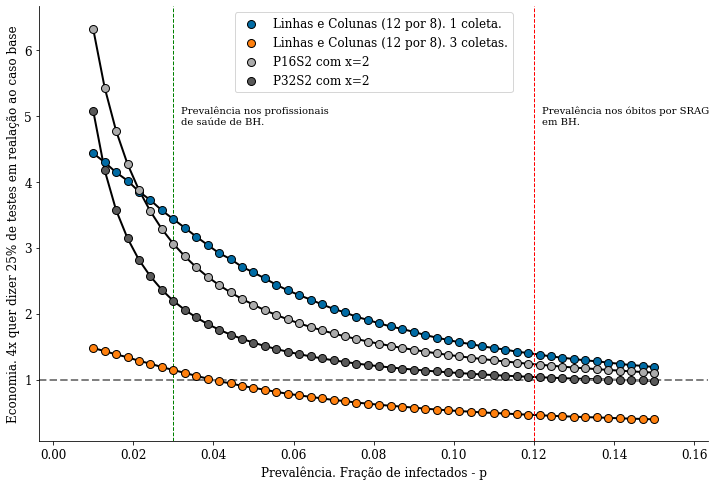

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

x = np.array(x)
ym = np.array(ym)
yp16s2 = np.array(yp16s2)
yp32s2 = np.array(yp32s2)

ax.scatter(x, 1.0 / (ym), s=64, edgecolor='k', zorder=2, label='Linhas e Colunas (12 por 8). 1 coleta.')
ax.plot(x, 1.0 / (ym), color='k', zorder=1, lw=2)

ax.scatter(x, 1.0 / (ym*3), s=64, edgecolor='k', zorder=2, label='Linhas e Colunas (12 por 8). 3 coletas.')
ax.plot(x, 1.0 / (ym*3), color='k', zorder=1, lw=2)

ax.scatter(x, 1.0 / yp16s2, s=64, edgecolor='k', zorder=2, label='P16S2 com x=2')
ax.plot(x, 1.0 / yp16s2, color='k', zorder=1, lw=2)

ax.scatter(x, 1.0 / yp32s2, s=64, edgecolor='k', zorder=2, label='P32S2 com x=2')
ax.plot(x, 1.0 / yp32s2, color='k', zorder=1, lw=2)

ax.axhline(1, ls='--', color='grey', lw=2, zorder=1)

ax.axvline(0.03, ls='--', lw=1, zorder=1, color='green')
ax.axvline(0.12, ls='--', lw=1, zorder=1, color='red')

ax.set_xlabel('Prevalência. Fração de infectados - p')
ax.set_ylabel('Economia. 4x quer dizer 25% de testes em realação ao caso base')

ax.text(0.032, 5, 'Prevalência nos profissionais\nde saúde de BH.',
        horizontalalignment='left', verticalalignment='center')

ax.text(0.122, 5, 'Prevalência nos óbitos por SRAG\nem BH.',
        horizontalalignment='left', verticalalignment='center')

plt.legend()

despine()

## Brincando um pouco com os métodos. Testes de Sanidade

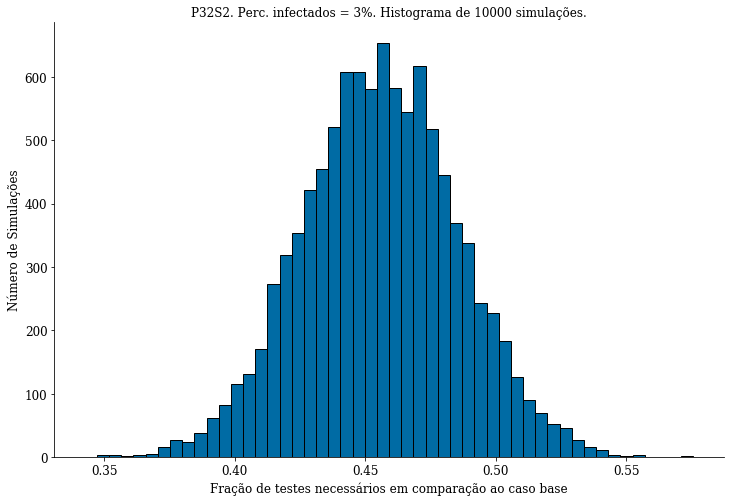

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

results = multi_pnsk(32, 2, 2, 0.03, 5000) / 5000

ax.set_title('P32S2. Perc. infectados = 3%. Histograma de 10000 simulações.')
ax.hist(results, bins=50, edgecolor='k')
ax.set_ylabel('Número de Simulações')
ax.set_xlabel('Fração de testes necessários em comparação ao caso base')
despine(ax)

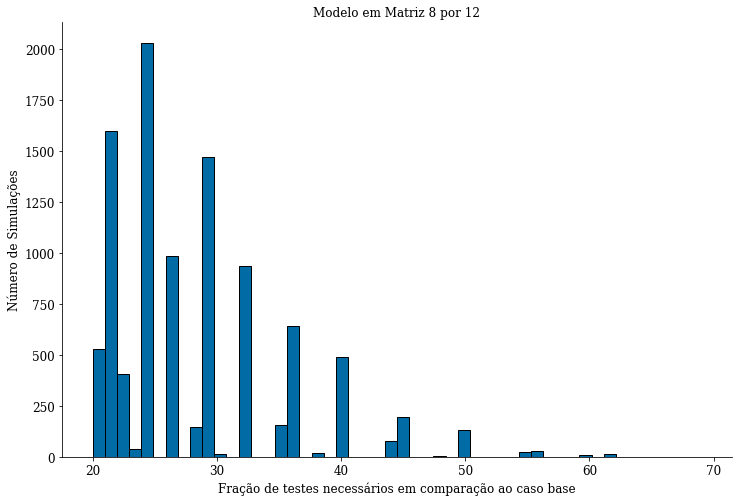

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

results = multi_matrix(8, 12, 0.03)

ax.set_title('Modelo em Matriz 8 por 12')
ax.hist(results, bins=50, edgecolor='k')
ax.set_ylabel('Número de Simulações')
ax.set_xlabel('Fração de testes necessários em comparação ao caso base')
despine(ax)

## Referências

1. Broder, Andrei Z., and Kumar, Ravi. "A Note on Double Pooling Tests." arXiv preprint arXiv:2004.01684 (2020). Online: https://arxiv.org/pdf/2004.01684.pdf 

1. Dorfman, Robert.  “The detection of defective members of large populations.” Ann MathStat., 14:436–440, 1943

1. Du, Ding-Zhu and Hwang, Frank K. “Combinatorial Group Testing and its Applications”. World Scientific, 1993.

1. Eberhardt, Jens Niklas., Breuckmann, Nikolas Peter., and Eberhardt, Christiane Sigrid. "Multi-Stage Group Testing Improves Efficiency of Large-Scale COVID-19 Screening." Journal of Clinical Virology (2020): 104382. Online: https://www.sciencedirect.com/science/article/pii/S1386653220301244 

1. Seifried, Erhard., et al. “Pool testing of SARS-CoV-2 samples increases test capacity.” (2020). Online: https://www.medica.de/de/News/Redaktionelle_News/Pool-Testen_von_SARS-CoV-2_Proben_erhoht_Testkapazitat. 

1. Gollier, Christian, and Olivier Gossner. "Group testing against Covid-19." Covid Economics 1.2 (2020): 32-42. Online: https://www.tse-fr.eu/sites/default/files/TSE/documents/doc/by/gollier/covid_economics.pdf 

1. Sinnott-Armstrong, Nasa., and Klein, Daniel L., and Hickey, Brendam. "Evaluation of Group Testing for SARS-CoV-2 RNA." medRxiv (2020). Online: https://www.medrxiv.org/content/10.1101/2020.03.27.20043968v1 

1. Yelin, Idan, et al. "Evaluation of COVID-19 RT-qPCR test in multi-sample pools." medRxiv (2020). Online: https://www.medrxiv.org/content/10.1101/2020.03.26.20039438v1 

1. Zhu, Na, et al. "A novel coronavirus from patients with pneumonia in China, 2019." New England Journal of Medicine (2020). Online: https://www.nejm.org/doi/full/10.1056/NEJMoa2001017 